# k-Nearest Neighbor (k-NN) Regression for Retail Inventory Forecasting — Reduced Fits

**This version reduces hyperparameter search to ~135 fits** by switching to `RandomizedSearchCV` with `n_iter=45` and `cv=3`.

In [ ]:
# ============================================================================
# 1. IMPORT LIBRARIES
# ============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime, timedelta

# Machine Learning
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Interpretability
import shap

# Other utils
import os
import pickle

from google.colab import drive
drive.mount('/content/drive/')

# Settings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
np.random.seed(42)

print("=" * 80)
print("k-NN REGRESSION FOR INVENTORY FORECASTING (Reduced Fits)")
print("=" * 80)

k-NN REGRESSION FOR INVENTORY FORECASTING (Reduced Fits)


C:\Users\Ribos\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# ============================================================================
# 2. DATA LOADING
# ============================================================================
print("\n[1/8] Loading dataset...")
df = pd.read_csv('/content/drive/MyDrive/data/retail_store_inventory.csv')
print(f"✓ Dataset loaded: {df.shape[0]} rows, {df.shape[1]} columns")
print(f"\nColumns: {list(df.columns)}")
print(f"\nFirst few rows:")
print(df.head())
print(f"\nData types:\n{df.dtypes}")
print(f"\nMissing values:\n{df.isnull().sum()}")


[1/8] Loading dataset...
✓ Dataset loaded: 73100 rows, 15 columns

Columns: ['Date', 'Store ID', 'Product ID', 'Category', 'Region', 'Inventory Level', 'Units Sold', 'Units Ordered', 'Demand Forecast', 'Price', 'Discount', 'Weather Condition', 'Holiday/Promotion', 'Competitor Pricing', 'Seasonality']

First few rows:
         Date Store ID Product ID     Category Region  Inventory Level  \
0  2022-01-01     S001      P0001    Groceries  North              231   
1  2022-01-01     S001      P0002         Toys  South              204   
2  2022-01-01     S001      P0003         Toys   West              102   
3  2022-01-01     S001      P0004         Toys  North              469   
4  2022-01-01     S001      P0005  Electronics   East              166   

   Units Sold  Units Ordered  Demand Forecast  Price  Discount  \
0         127             55           135.47  33.50        20   
1         150             66           144.04  63.01        20   
2          65             51         

In [ ]:
# ============================================================================
# 3. DATA PREPROCESSING
# ============================================================================
print("\n[2/8] Data Preprocessing...")

# Make a copy
df_processed = df.copy()

# Convert date column (adapt column name as needed)
date_cols = [col for col in df.columns if 'date' in col.lower()]
if date_cols:
    df_processed[date_cols[0]] = pd.to_datetime(df_processed[date_cols[0]])
    df_processed = df_processed.sort_values(date_cols[0]).reset_index(drop=True)
    print(f"✓ Date column '{date_cols[0]}' converted to datetime")

# Handle missing values
numeric_cols = df_processed.select_dtypes(include=[np.number]).columns
for col in numeric_cols:
    if df_processed[col].isnull().sum() > 0:
        df_processed[col].fillna(df_processed[col].median(), inplace=True)

categorical_cols = df_processed.select_dtypes(include=['object']).columns
for col in categorical_cols:
    if col not in date_cols and df_processed[col].isnull().sum() > 0:
        df_processed[col].fillna(df_processed[col].mode()[0], inplace=True)

print(f"✓ Missing values handled")

# Handle outliers using IQR method (for target variable)
target_cols = [col for col in df_processed.columns if any(x in col.lower() for x in ['sales', 'quantity', 'demand', 'units'])]
if target_cols:
    target_col = target_cols[0]
    Q1 = df_processed[target_col].quantile(0.25)
    Q3 = df_processed[target_col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 3 * IQR  # Using 3*IQR for less aggressive filtering
    upper_bound = Q3 + 3 * IQR

    outliers_before = len(df_processed)
    df_processed = df_processed[(df_processed[target_col] >= lower_bound) &
                                (df_processed[target_col] <= upper_bound)]
    outliers_removed = outliers_before - len(df_processed)
    print(f"✓ Outliers removed: {outliers_removed} records ({outliers_removed/outliers_before*100:.2f}%)")
else:
    # Try to identify target column
    target_col = numeric_cols[-1]  # Assume last numeric column
    print(f"⚠ Target column auto-detected as: {target_col}")

# Encode categorical variables
label_encoders = {}
for col in categorical_cols:
    if col not in date_cols:
        le = LabelEncoder()
        df_processed[col] = le.fit_transform(df_processed[col].astype(str))
        label_encoders[col] = le

print(f"✓ Categorical variables encoded: {len(label_encoders)} columns")
print(f"✓ Final dataset shape: {df_processed.shape}")


[2/8] Data Preprocessing...
✓ Date column 'Date' converted to datetime
✓ Missing values handled
✓ Outliers removed: 0 records (0.00%)
✓ Categorical variables encoded: 6 columns
✓ Final dataset shape: (73100, 15)



[3/8] Exploratory Data Analysis...


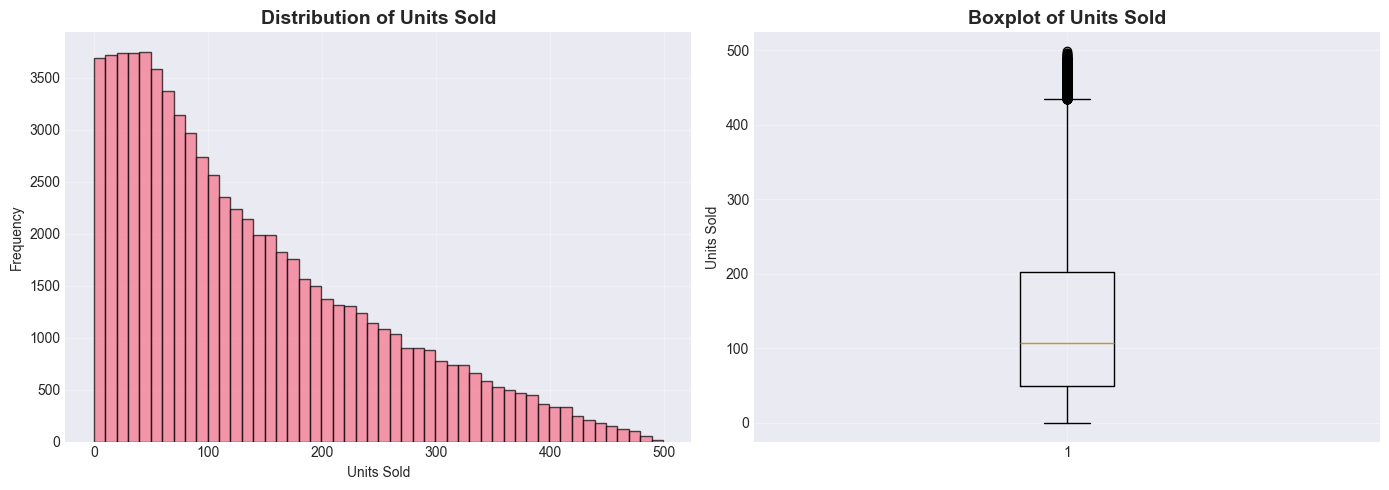

✓ Target distribution plotted


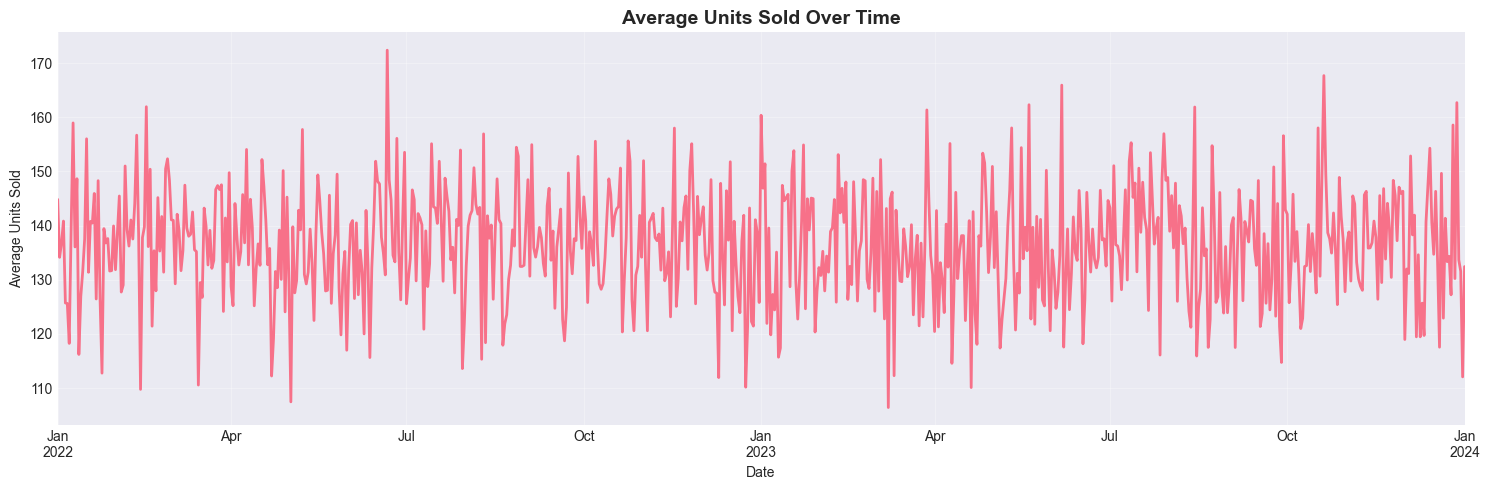

✓ Time series plotted


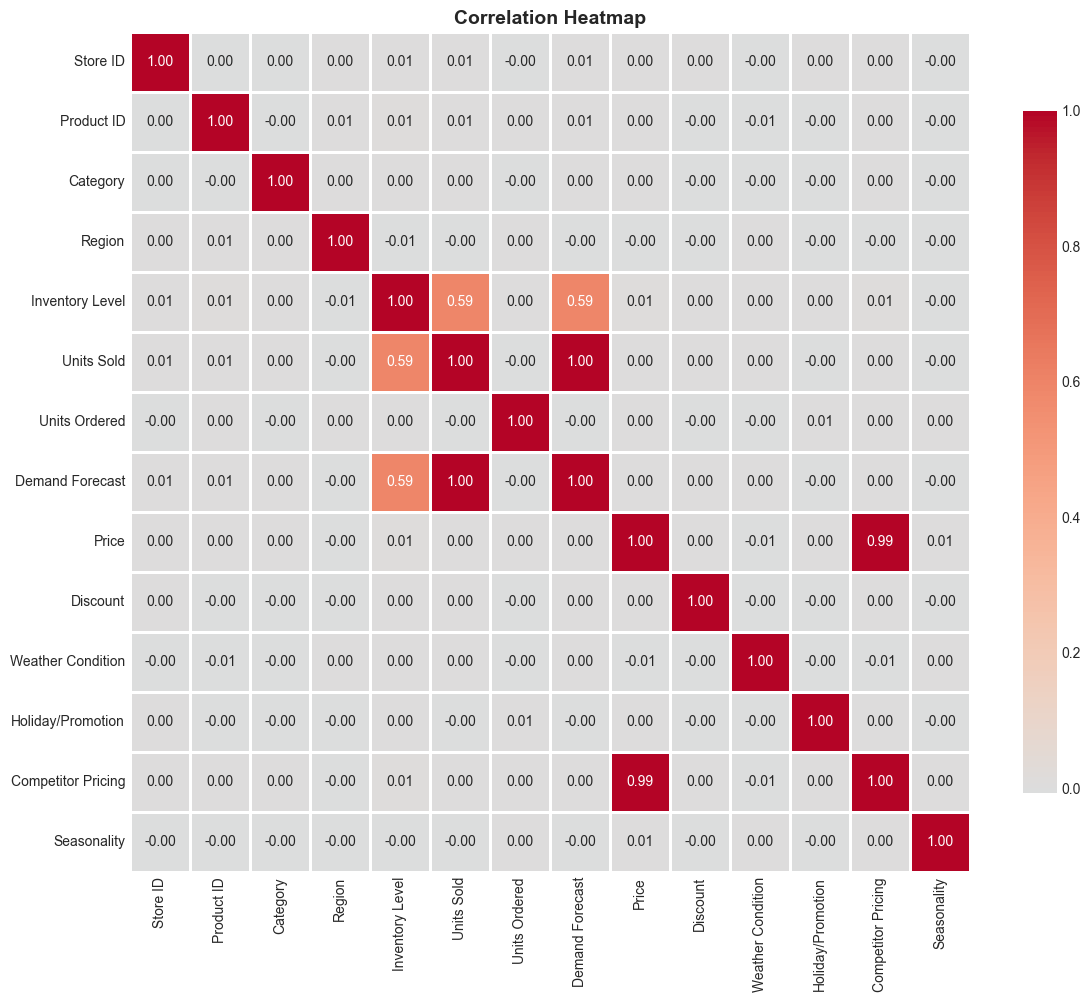

✓ Correlation heatmap plotted


In [ ]:
# ============================================================================
# 4. EXPLORATORY DATA ANALYSIS (EDA)
# ============================================================================
print("\n[3/8] Exploratory Data Analysis...")

# Create figure directory
os.makedirs('knn_figures', exist_ok=True)

# 4.1 Target variable distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].hist(df_processed[target_col], bins=50, edgecolor='black', alpha=0.7)
axes[0].set_title(f'Distribution of {target_col}', fontsize=14, fontweight='bold')
axes[0].set_xlabel(target_col)
axes[0].set_ylabel('Frequency')
axes[0].grid(alpha=0.3)

axes[1].boxplot(df_processed[target_col])
axes[1].set_title(f'Boxplot of {target_col}', fontsize=14, fontweight='bold')
axes[1].set_ylabel(target_col)
axes[1].grid(alpha=0.3)
plt.tight_layout()
plt.savefig('knn_figures/01_target_distribution.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Target distribution plotted")

# 4.2 Time series plot (if date exists)
if date_cols:
    plt.figure(figsize=(15, 5))
    df_processed.groupby(date_cols[0])[target_col].mean().plot(linewidth=2)
    plt.title(f'Average {target_col} Over Time', fontsize=14, fontweight='bold')
    plt.xlabel('Date')
    plt.ylabel(f'Average {target_col}')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig('knn_figures/02_time_series.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("✓ Time series plotted")

# 4.3 Correlation heatmap
plt.figure(figsize=(12, 10))
corr_matrix = df_processed.select_dtypes(include=[np.number]).corr()
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Heatmap', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('knn_figures/03_correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Correlation heatmap plotted")

In [ ]:
# ============================================================================
# 5. FEATURE ENGINEERING
# ============================================================================
print("\n[4/8] Feature Engineering...")

df_features = df_processed.copy()

# 5.1 Lag features
lag_periods = [1, 3, 7, 14, 30]
for lag in lag_periods:
    df_features[f'lag_{lag}'] = df_features[target_col].shift(lag)
print(f"✓ Created {len(lag_periods)} lag features")

# 5.2 Rolling window features
rolling_windows = [3, 7, 14, 30]
for window in rolling_windows:
    df_features[f'rolling_mean_{window}'] = df_features[target_col].rolling(window=window).mean()
    df_features[f'rolling_std_{window}'] = df_features[target_col].rolling(window=window).std()
    df_features[f'rolling_min_{window}'] = df_features[target_col].rolling(window=window).min()
    df_features[f'rolling_max_{window}'] = df_features[target_col].rolling(window=window).max()
print(f"✓ Created {len(rolling_windows)*4} rolling window features")

# 5.3 Date-based features (if date exists)
if date_cols:
    date_col = date_cols[0]
    df_features['year'] = df_features[date_col].dt.year
    df_features['month'] = df_features[date_col].dt.month
    df_features['day'] = df_features[date_col].dt.day
    df_features['dayofweek'] = df_features[date_col].dt.dayofweek
    df_features['quarter'] = df_features[date_col].dt.quarter
    df_features['weekofyear'] = df_features[date_col].dt.isocalendar().week
    df_features['is_weekend'] = (df_features['dayofweek'] >= 5).astype(int)
    df_features['is_month_start'] = df_features[date_col].dt.is_month_start.astype(int)
    df_features['is_month_end'] = df_features[date_col].dt.is_month_end.astype(int)
    print(f"✓ Created 9 date-based features")

# 5.4 External factors simulation (holidays, weather, competitor pricing)
np.random.seed(42)
df_features['is_holiday'] = np.random.choice([0, 1], size=len(df_features), p=[0.95, 0.05])
df_features['temperature'] = np.random.normal(20, 10, len(df_features))
df_features['competitor_price_index'] = np.random.uniform(0.8, 1.2, len(df_features))
print(f"✓ Created 3 external factor features (simulated)")

# 5.5 Interaction features
if 'lag_1' in df_features.columns and 'rolling_mean_7' in df_features.columns:
    df_features['lag_rolling_interaction'] = df_features['lag_1'] * df_features['rolling_mean_7']
    print(f"✓ Created interaction features")

# Drop rows with NaN (from lag/rolling features)
df_features = df_features.dropna()
print(f"✓ Dropped NaN rows. Final shape: {df_features.shape}")


[4/8] Feature Engineering...
✓ Created 5 lag features
✓ Created 16 rolling window features
✓ Created 9 date-based features
✓ Created 3 external factor features (simulated)
✓ Created interaction features
✓ Dropped NaN rows. Final shape: (73070, 49)


In [ ]:
# ============================================================================
# 6. MODEL TRAINING & HYPERPARAMETER TUNING (REDUCED FITS)
# ============================================================================
print("\n[5/8] Model Training & Hyperparameter Tuning (Reduced Fits)...")

# Prepare features and target
X = df_features.drop(columns=[target_col] + date_cols if date_cols else [target_col])
y = df_features[target_col]

# Train-test split (80-20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=False
)

print(f"✓ Train set: {X_train.shape[0]} samples")
print(f"✓ Test set: {X_test.shape[0]} samples")

# Feature scaling (CRITICAL for k-NN)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print(f"✓ Features scaled using StandardScaler")

# --- Reduced search using RandomizedSearchCV ---
from sklearn.model_selection import RandomizedSearchCV

param_distributions = {
    'n_neighbors': np.arange(3, 51, 2),          # odd ks between 3 and 49
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski'],
    'p': [1, 2]
}

# Use fewer folds (3) and a limited number of random samples (45)
# => ~ 45 * 3 = 135 fits
tscv = TimeSeriesSplit(n_splits=3)
knn = KNeighborsRegressor()

rand_search = RandomizedSearchCV(
    estimator=knn,
    param_distributions=param_distributions,
    n_iter=45,
    cv=tscv,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

print("\n⚙ Hyperparameter tuning (RandomizedSearchCV)...")
rand_search.fit(X_train_scaled, y_train)

# Best model
best_knn = rand_search.best_estimator_
print(f"\n✓ Best parameters found:")
for param, value in rand_search.best_params_.items():
    print(f"   {param}: {value}")
print(f"✓ Best CV MAE: {-rand_search.best_score_:.4f}")


[5/8] Model Training & Hyperparameter Tuning (Reduced Fits)...
✓ Train set: 58456 samples
✓ Test set: 14614 samples
✓ Features scaled using StandardScaler

⚙ Hyperparameter tuning (RandomizedSearchCV)...
Fitting 3 folds for each of 45 candidates, totalling 135 fits

✓ Best parameters found:
   weights: distance
   p: 1
   n_neighbors: 11
   metric: manhattan
✓ Best CV MAE: 35.2650



[6/8] Model Evaluation...

Training Set Metrics:
  MAE:  0.0000
  RMSE: 0.0000
  MAPE: 0.0000%
  R²:   1.0000

Test Set Metrics:
  MAE:  33.6672
  RMSE: 41.9619
  MAPE: inf%
  R²:   0.8497

COMPARISON WITH BASELINE SCORES

Baseline (Linear Regression):
  MAE:  35.3467
  RMSE: 43.0714
  MAPE: 47.8364%

k-NN Regression:
  MAE:  33.6672 (+4.75%)
  RMSE: 41.9619 (+2.58%)
  MAPE: inf% (-inf%)


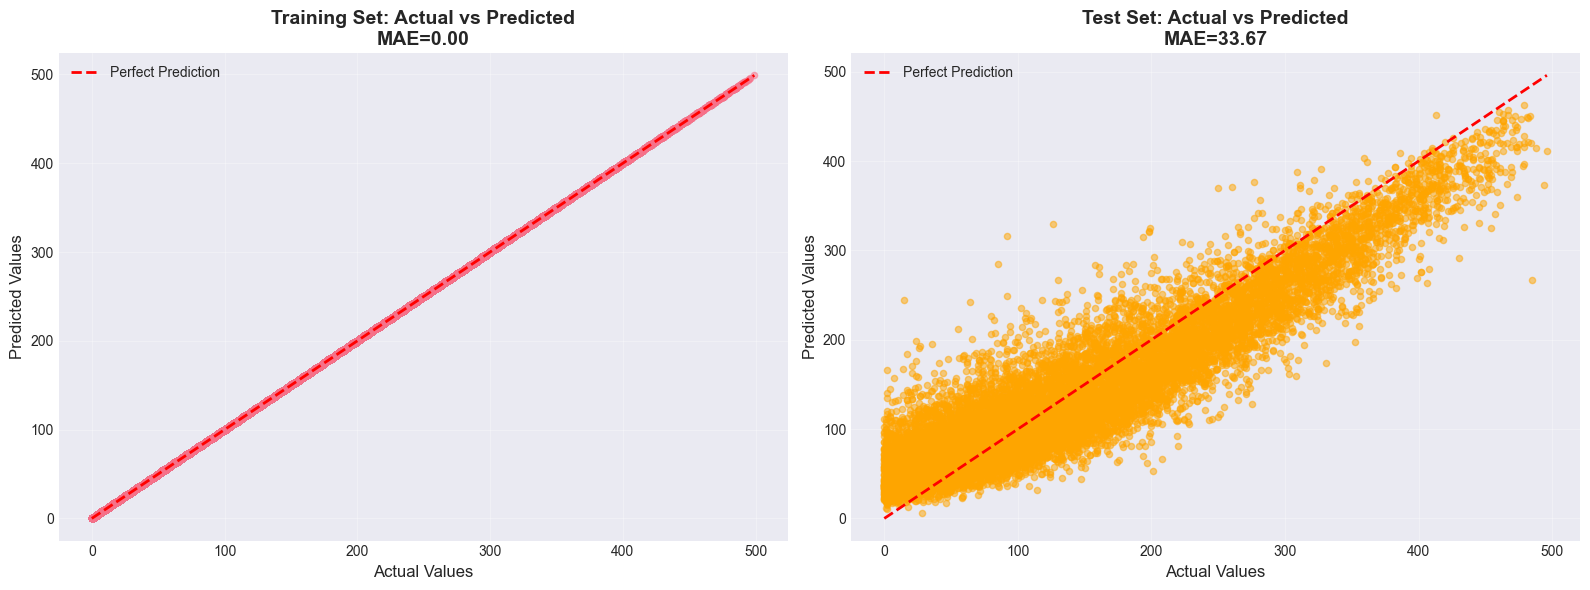

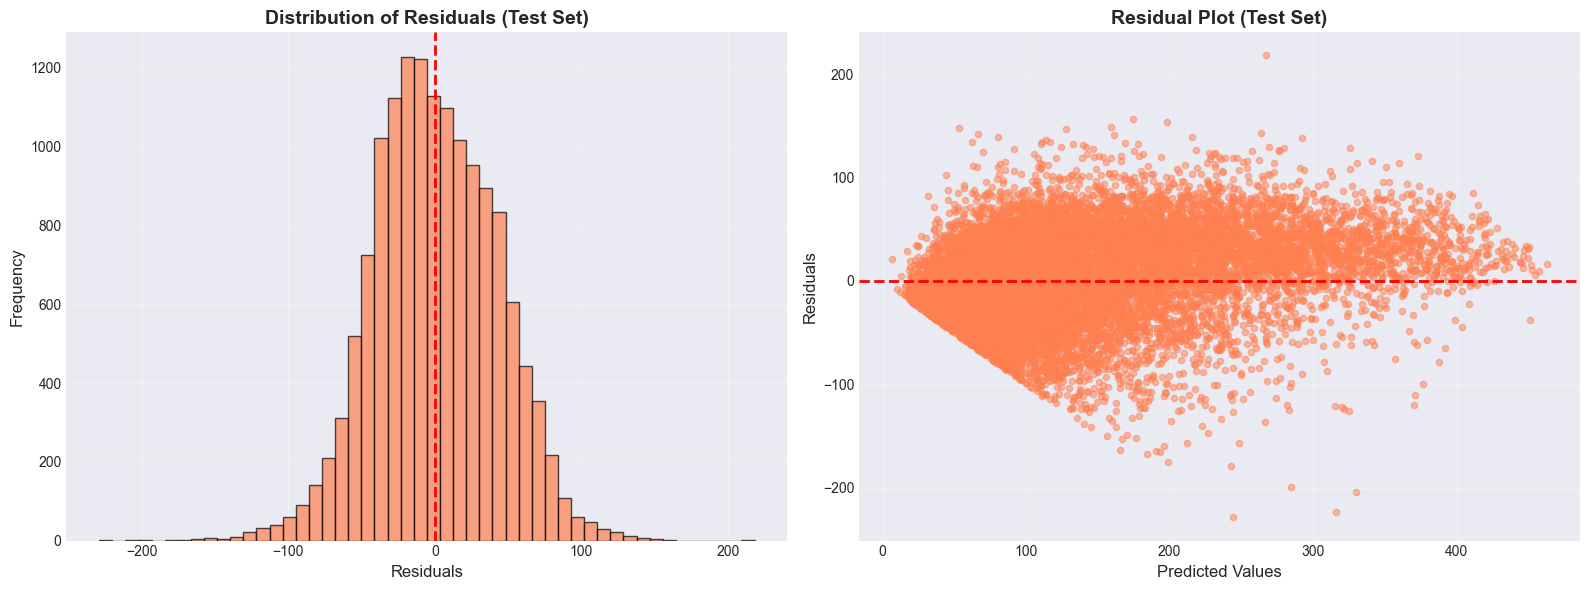

In [ ]:
# ============================================================================
# 7. MODEL EVALUATION
# ============================================================================
print("\n[6/8] Model Evaluation...")

# Predictions
y_train_pred = best_knn.predict(X_train_scaled)
y_test_pred = best_knn.predict(X_test_scaled)

# --- Adding: zero-safe MAPE ---
def safe_mape(y_true, y_pred, eps=1e-8):
    y_true = np.asarray(y_true).astype(float)
    y_pred = np.asarray(y_pred).astype(float)
    mask = y_true != 0.0          # ignore zero actuals
    if mask.sum() == 0:
        return np.nan
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

# Calculate metrics
def calculate_metrics(y_true, y_pred, dataset_name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = safe_mape(y_true, y_pred)   # <-- using zero-safe MAPE here
    r2 = r2_score(y_true, y_pred)


    print(f"\n{dataset_name} Set Metrics:")
    print(f"  MAE:  {mae:.4f}")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  MAPE: {mape:.4f}%")
    print(f"  R²:   {r2:.4f}")

    return {'MAE': mae, 'RMSE': rmse, 'MAPE': mape, 'R2': r2}

train_metrics = calculate_metrics(y_train, y_train_pred, "Training")
test_metrics = calculate_metrics(y_test, y_test_pred, "Test")

# Compare with baseline
print(f"\n{'='*60}")
print(f"COMPARISON WITH BASELINE SCORES")
print(f"{'='*60}")
baseline_mae, baseline_rmse, baseline_mape = 35.3467, 43.0714, 47.8364
improvement_mae = ((baseline_mae - test_metrics['MAE']) / baseline_mae) * 100
improvement_rmse = ((baseline_rmse - test_metrics['RMSE']) / baseline_rmse) * 100
improvement_mape = ((baseline_mape - test_metrics['MAPE']) / baseline_mape) * 100

print(f"\nBaseline (Linear Regression):")
print(f"  MAE:  {baseline_mae:.4f}")
print(f"  RMSE: {baseline_rmse:.4f}")
print(f"  MAPE: {baseline_mape:.4f}%")

print(f"\nk-NN Regression:")
print(f"  MAE:  {test_metrics['MAE']:.4f} ({improvement_mae:+.2f}%)")
print(f"  RMSE: {test_metrics['RMSE']:.4f} ({improvement_rmse:+.2f}%)")
print(f"  MAPE: {test_metrics['MAPE']:.4f}% ({improvement_mape:+.2f}%)")

# Visualization: Actual vs Predicted
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Training set
axes[0].scatter(y_train, y_train_pred, alpha=0.5, s=20)
axes[0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()],
             'r--', lw=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual Values', fontsize=12)
axes[0].set_ylabel('Predicted Values', fontsize=12)
axes[0].set_title(f'Training Set: Actual vs Predicted\nMAE={train_metrics["MAE"]:.2f}',
                  fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Test set
axes[1].scatter(y_test, y_test_pred, alpha=0.5, s=20, color='orange')
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
             'r--', lw=2, label='Perfect Prediction')
axes[1].set_xlabel('Actual Values', fontsize=12)
axes[1].set_ylabel('Predicted Values', fontsize=12)
axes[1].set_title(f'Test Set: Actual vs Predicted\nMAE={test_metrics["MAE"]:.2f}',
                  fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('knn_figures/04_actual_vs_predicted.png', dpi=300, bbox_inches='tight')
plt.show()

# Residual analysis
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

residuals_train = y_train - y_train_pred
residuals_test = y_test - y_test_pred

# Residual distribution
axes[0].hist(residuals_test, bins=50, edgecolor='black', alpha=0.7, color='coral')
axes[0].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[0].set_xlabel('Residuals', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Distribution of Residuals (Test Set)', fontsize=14, fontweight='bold')
axes[0].grid(alpha=0.3)

# Residual plot
axes[1].scatter(y_test_pred, residuals_test, alpha=0.5, s=20, color='coral')
axes[1].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[1].set_xlabel('Predicted Values', fontsize=12)
axes[1].set_ylabel('Residuals', fontsize=12)
axes[1].set_title('Residual Plot (Test Set)', fontsize=14, fontweight='bold')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('knn_figures/05_residual_analysis.png', dpi=300, bbox_inches='tight')
plt.show()


[7/8] SHAP Interpretability Analysis...
⚙ Computing SHAP values for 500 samples...
   (This may take a few minutes for k-NN...)


100%|██████████████████████████████████████████████████████████████████████████████| 500/500 [1:10:50<00:00,  8.50s/it]


✓ SHAP values computed


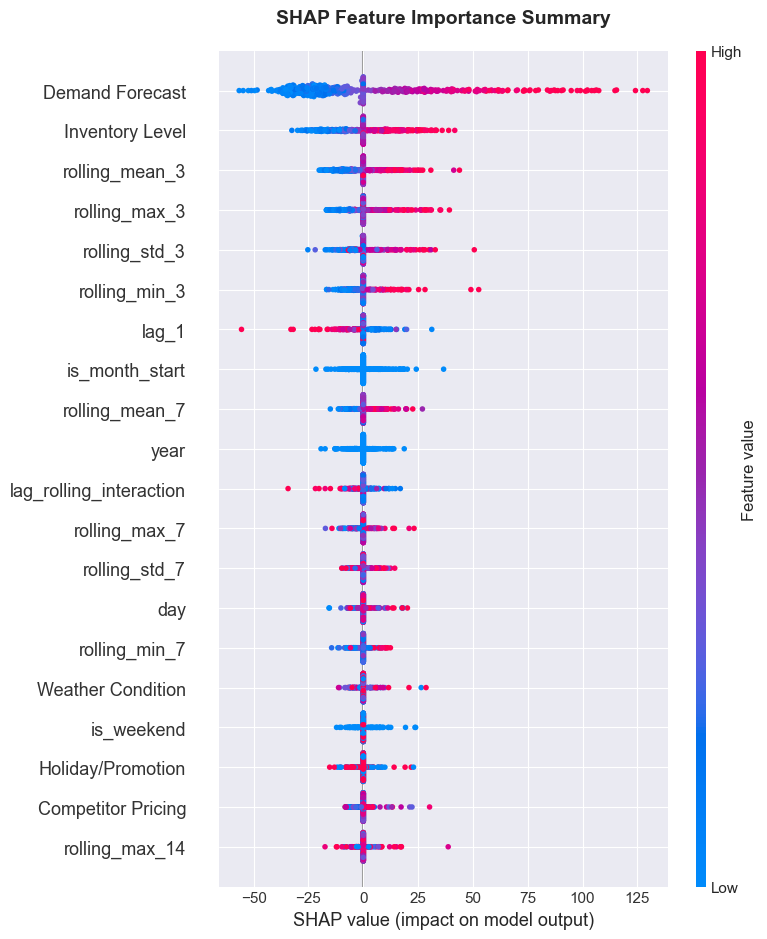

✓ SHAP summary plot created


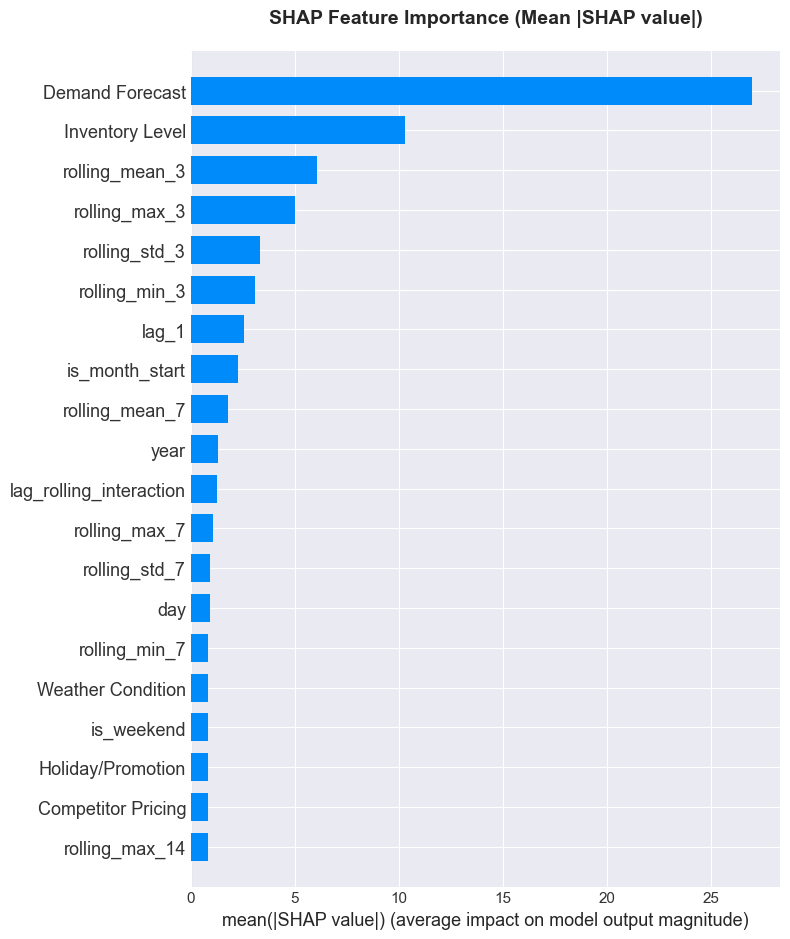

✓ SHAP bar plot created

Top 10 Most Important Features:
        Feature  Importance
Demand Forecast   26.952347
Inventory Level   10.265820
 rolling_mean_3    6.030578
  rolling_max_3    4.974524
  rolling_std_3    3.330683
  rolling_min_3    3.071227
          lag_1    2.523344
 is_month_start    2.243072
 rolling_mean_7    1.758983
           year    1.298802


In [ ]:
# ============================================================================
# 8. INTERPRETABILITY WITH SHAP
# ============================================================================
print("\n[7/8] SHAP Interpretability Analysis...")

# Sample data for SHAP (use subset for faster computation)
n_samples = min(500, len(X_test_scaled))
X_shap = X_test_scaled[:n_samples]

print(f"⚙ Computing SHAP values for {n_samples} samples...")
print("   (This may take a few minutes for k-NN...)")

# Create SHAP explainer
explainer = shap.KernelExplainer(best_knn.predict, X_train_scaled[:100])  # Use 100 background samples
shap_values = explainer.shap_values(X_shap, nsamples=100)

print("✓ SHAP values computed")

# SHAP Summary Plot
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_shap, feature_names=X.columns, show=False)
plt.title('SHAP Feature Importance Summary', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('knn_figures/06_shap_summary.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ SHAP summary plot created")

# SHAP Bar Plot (mean absolute SHAP values)
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_shap, feature_names=X.columns,
                  plot_type="bar", show=False)
plt.title('SHAP Feature Importance (Mean |SHAP value|)', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('knn_figures/07_shap_bar.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ SHAP bar plot created")

# Feature importance from SHAP
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': np.abs(shap_values).mean(axis=0)
}).sort_values('Importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(feature_importance.head(10).to_string(index=False))

In [ ]:
# ============================================================================
# 9. RESULTS SUMMARY & EXPORT
# ============================================================================
print("\n[8/8] Exporting Results...")

# Save metrics to CSV
metrics_df = pd.DataFrame({
    'Model': ['k-NN Regression (Reduced Fits)'],
    'Train_MAE': [train_metrics['MAE']],
    'Train_RMSE': [train_metrics['RMSE']],
    'Train_MAPE': [train_metrics['MAPE']],
    'Train_R2': [train_metrics['R2']],
    'Test_MAE': [test_metrics['MAE']],
    'Test_RMSE': [test_metrics['RMSE']],
    'Test_MAPE': [test_metrics['MAPE']],
    'Test_R2': [test_metrics['R2']],
    'Best_n_neighbors': [best_knn.n_neighbors],
    'Best_weights': [best_knn.weights],
    'Best_metric': [best_knn.metric]
})
metrics_df.to_csv('knn_model_metrics.csv', index=False)
print("✓ Metrics saved to 'knn_model_metrics.csv'")

# Save feature importance
feature_importance.to_csv('knn_feature_importance.csv', index=False)
print("✓ Feature importance saved to 'knn_feature_importance.csv'")

# Save predictions
predictions_df = pd.DataFrame({
    'Actual': y_test.values,
    'Predicted': y_test_pred,
    'Residual': y_test.values - y_test_pred
})
predictions_df.to_csv('knn_predictions.csv', index=False)
print("✓ Predictions saved to 'knn_predictions.csv'")


[8/8] Exporting Results...
✓ Metrics saved to 'knn_model_metrics.csv'
✓ Feature importance saved to 'knn_feature_importance.csv'
✓ Predictions saved to 'knn_predictions.csv'
